- ref for COCO from YOLO: https://github.com/Taeyoung96/Yolo-to-COCO-format-converter 

In [8]:
# As of 0.3 the XYWHA_ABS box is not supported in the visualizer, this is fixed in master branch atm (19/11/20)
class myVisualizer(Visualizer):
  
    def draw_dataset_dict(self, dic):
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYWHA_ABS) for x in annos]

            labels = [x["category_id"] for x in annos]
#             labels = [np.round(x["bbox"][-1]) for x in annos]
            names = self.metadata.get("thing_classes", None)
            if names:
                labels = [names[i] for i in labels]
            labels = [
                "{}".format(i) + ("|crowd" if a.get("iscrowd", 0) else "")
                for i, a in zip(labels, annos)
            ]
            self.overlay_instances(labels=labels, boxes=boxes, masks=masks, keypoints=keypts)

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            sem_seg = cv2.imread(dic["sem_seg_file_name"], cv2.IMREAD_GRAYSCALE)
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)
        return self.output

# Create dataset

In [1]:
import os

key_words = ['train', 'val'] 
for key_word in key_words:
    dir_annotations = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_{key_word}/'
    files = []
    for f in os.listdir(dir_annotations):
        if f[-3:] == 'tif':
            files.append(dir_annotations + f + '\n')

    img_files_file = dir_annotations + 'img_files.txt'
    file = open(img_files_file, "w")
    file.writelines(files)
    file.close()

In [11]:
import cv2
import json
import numpy as np
from detectron2.structures import Boxes, BoxMode, PolygonMasks
import math
import os

def create_image_annotation(file_name, width, height, image_id):
    file_name = file_name.split('/')[-1] # ~~~.jpg가 file_name이 되도록 문자열 split
    images = {
        'file_name': file_name,
        'height': height,
        'width': width,
        'id': image_id
    }
    return images

def create_annotation_yolo_format(xc, yc, width, height, ang, image_id, category_id, annotation_id):
    bbox = (xc, yc, width, height, ang)
    area = width * height

    annotation = {
        'id': annotation_id,
        'image_id': image_id,
        'bbox': bbox,
        'bbox_mode': BoxMode.XYWHA_ABS,
        'area': area,
        'iscrowd': 0,
        'category_id': category_id,
        'segmentation': []
    }

    return annotation


In [2]:
#################################################
# Change the classes depend on your own dataset.#
# Don't change the list name 'Classes'          #
#################################################

classes = [
'rod_o',
'rod_c',
'rod_s',
'poly_o',
'poly_c',
'poly_s',
]

# Create the annotations of the ECP dataset (Coco format)
coco_format = {
    "images": [
        {
        }
    ],
    "categories": [

    ],
    "annotations": [
        {
        }
    ]
}

# Get 'images' and 'annotations' info
def images_annotations_info(path):

    # path : train.txt or test.txt
    annotations = []
    images = []

    file = open(path, "r")
    read_lines = file.readlines()
    file.close()

    image_id = 0
    annotation_id = 1   # In COCO dataset format, you must start annotation id with '1'

    for img_fname in read_lines:
        # Check how many items have progressed
        print("Processing " + str(image_id) + " ...")

        img_fname = img_fname.replace('\n', '')
        img_file = cv2.imread(img_fname)

        # read a label file
        label_path = img_fname[:-3]+"txt"
        label_file = open(label_path,"r")
        label_read_line = label_file.readlines()
        label_file.close()

        h, w, _ = img_file.shape

        # Create image annotation
        image = create_image_annotation(img_fname, w, h, image_id)
        images.append(image)

        # yolo format - (class_id, x_center, y_center, width, height)
        # coco format - (annotation_id, x_upper_left, y_upper_left, width, height)
        for bbox in label_read_line:
            label_line = bbox
            category_id = int(label_line.split()[0])
            x_center = float(label_line.split()[1])
            y_center = float(label_line.split()[2])
            width = float(label_line.split()[3])
            height = float(label_line.split()[4])
            ang = 360 - math.degrees(float(label_line.split()[5]))
            if ang > 180:
                ang = ang - 180

            annotation = create_annotation_yolo_format(x_center, y_center, width, height, ang, image_id, category_id, annotation_id)
            annotations.append(annotation)
            annotation_id += 1

        image_id += 1  # if you finished annotation work, updates the image id.

    return images, annotations


for key_word in ['train', 'val']:
    img_files_file = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_{key_word}/img_files.txt'
    output_file = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_{key_word}_coco/{key_word}.json'
    
    coco_format['images'], coco_format['annotations'] = images_annotations_info(img_files_file)

    for index, label in enumerate(classes):
        ann = {
            "supercategory": "NanoRod",
            "id": index + 1,  # Index starts with '1' .
            "name": label
        }
        coco_format['categories'].append(ann)

    with open(output_file, 'w') as outfile:
        json.dump(coco_format, outfile)
    
    if key_word == 'train':
        coco_format['categories'] = []


Processing 0 ...
Processing 1 ...
Processing 2 ...
Processing 3 ...
Processing 4 ...
Processing 5 ...
Processing 6 ...
Processing 7 ...
Processing 8 ...
Processing 9 ...
Processing 10 ...
Processing 11 ...
Processing 12 ...
Processing 13 ...
Processing 14 ...
Processing 15 ...
Processing 16 ...
Processing 17 ...
Processing 18 ...


FileNotFoundError: [Errno 2] No such file or directory: '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train_2classes_coco/train.json'

In [1]:
# coco_format

In [23]:
#################################################
# Change the classes depend on your own dataset.#
# Don't change the list name 'Classes'          #
#################################################

classes_two = [
'rod_noOverlap',
'poly_noOverlap',
]

# Create the annotations of the ECP dataset (Coco format)
coco_format = {
    "images": [
        {
        }
    ],
    "categories": [

    ],
    "annotations": [
        {
        }
    ]
}

# Get 'images' and 'annotations' info
def images_annotations_info(path):

    # path : train.txt or test.txt
    annotations = []
    images = []

    file = open(path, "r")
    read_lines = file.readlines()
    file.close()

    image_id = 0
    annotation_id = 1   # In COCO dataset format, you must start annotation id with '1'

    for img_fname in read_lines:
        # Check how many items have progressed
        print("Processing " + str(image_id) + " ...")

        img_fname = img_fname.replace('\n', '')
        img_file = cv2.imread(img_fname)

        # read a label file
        label_path = img_fname[:-3]+"txt"
        label_file = open(label_path,"r")
        label_read_line = label_file.readlines()
        label_file.close()

        h, w, _ = img_file.shape

        # Create image annotation
        image = create_image_annotation(img_fname, w, h, image_id)
        images.append(image)

        # yolo format - (class_id, x_center, y_center, width, height)
        # coco format - (annotation_id, x_upper_left, y_upper_left, width, height)
        for bbox in label_read_line:
            label_line = bbox
            category_id = int(label_line.split()[0])
            if category_id != 1 and category_id != 4:
                continue
            else:
                if category_id <= 3:
                    category_id = int(1)
                else:
                    category_id = int(2)
                x_center = float(label_line.split()[1])
                y_center = float(label_line.split()[2])
                width = float(label_line.split()[3])
                height = float(label_line.split()[4])
                ang = 360 - math.degrees(float(label_line.split()[5]))
                if ang > 180:
                    ang = ang - 180

                annotation = create_annotation_yolo_format(x_center, y_center, width, height, ang, image_id, category_id, annotation_id)
                annotations.append(annotation)
                annotation_id += 1

        image_id += 1  # if you finished annotation work, updates the image id.

    return images, annotations


for key_word in ['train', 'val']:
    img_files_file = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_{key_word}/img_files.txt'
    output_file = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_{key_word}_noOverlap_coco/{key_word}.json'
    
    coco_format['images'], coco_format['annotations'] = images_annotations_info(img_files_file)

    for index, label in enumerate(classes_two):
        ann = {
            "supercategory": "NanoRod",
            "id": index + 1,  # Index starts with '1' .
            "name": label
        }
        coco_format['categories'].append(ann)

    with open(output_file, 'w') as outfile:
        json.dump(coco_format, outfile)
    
    if key_word == 'train':
        coco_format['categories'] = []


Processing 0 ...
Processing 1 ...
Processing 2 ...
Processing 3 ...
Processing 4 ...
Processing 5 ...
Processing 6 ...
Processing 7 ...
Processing 8 ...
Processing 9 ...
Processing 10 ...
Processing 11 ...
Processing 12 ...
Processing 13 ...
Processing 14 ...
Processing 15 ...
Processing 16 ...
Processing 17 ...
Processing 18 ...
Processing 0 ...
Processing 1 ...


In [24]:
tmp = set()
for anno in coco_format['annotations']:
    tmp.add(anno['category_id'])
    
tmp


{1, 2}

# Visualize data

In [5]:
import detectron2
import contextlib
import datetime
import io
import os
import threading
import pickle
import json
import logging
import cv2
import random
import numpy as np
import copy,torch,torchvision
import PIL
from PIL import Image
import xml.etree.ElementTree as X
import math
from itertools import repeat
import glob
import time
import shutil
from multiprocessing.pool import ThreadPool
import concurrent.futures
import torch

from fvcore.common.file_io import PathManager
from fvcore.common.timer import Timer

from detectron2.structures import Boxes, BoxMode, PolygonMasks
from detectron2.config import *
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import RotatedCOCOEvaluator,DatasetEvaluators, inference_on_dataset, coco_evaluation,DatasetEvaluator
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import matplotlib.pyplot as plt


# torch.cuda.set_device(0)

from helpers_coco import register_coco_instances_rbbox

setup_logger()

<Logger detectron2 (DEBUG)>

In [6]:
EXPERIMENT_NAME = 'nanorods'
dataset_train = EXPERIMENT_NAME + '_train'
dataset_val = EXPERIMENT_NAME + '_val'

DatasetCatalog.clear()
for dataset in [dataset_train, dataset_val]:
    key_word = dataset[len(EXPERIMENT_NAME)+1:]
    img_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_{key_word}/'
    annotation_file = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_{key_word}_coco/{key_word}.json'
    register_coco_instances_rbbox(dataset, {}, 
                                  annotation_file, 
                                  img_dir)


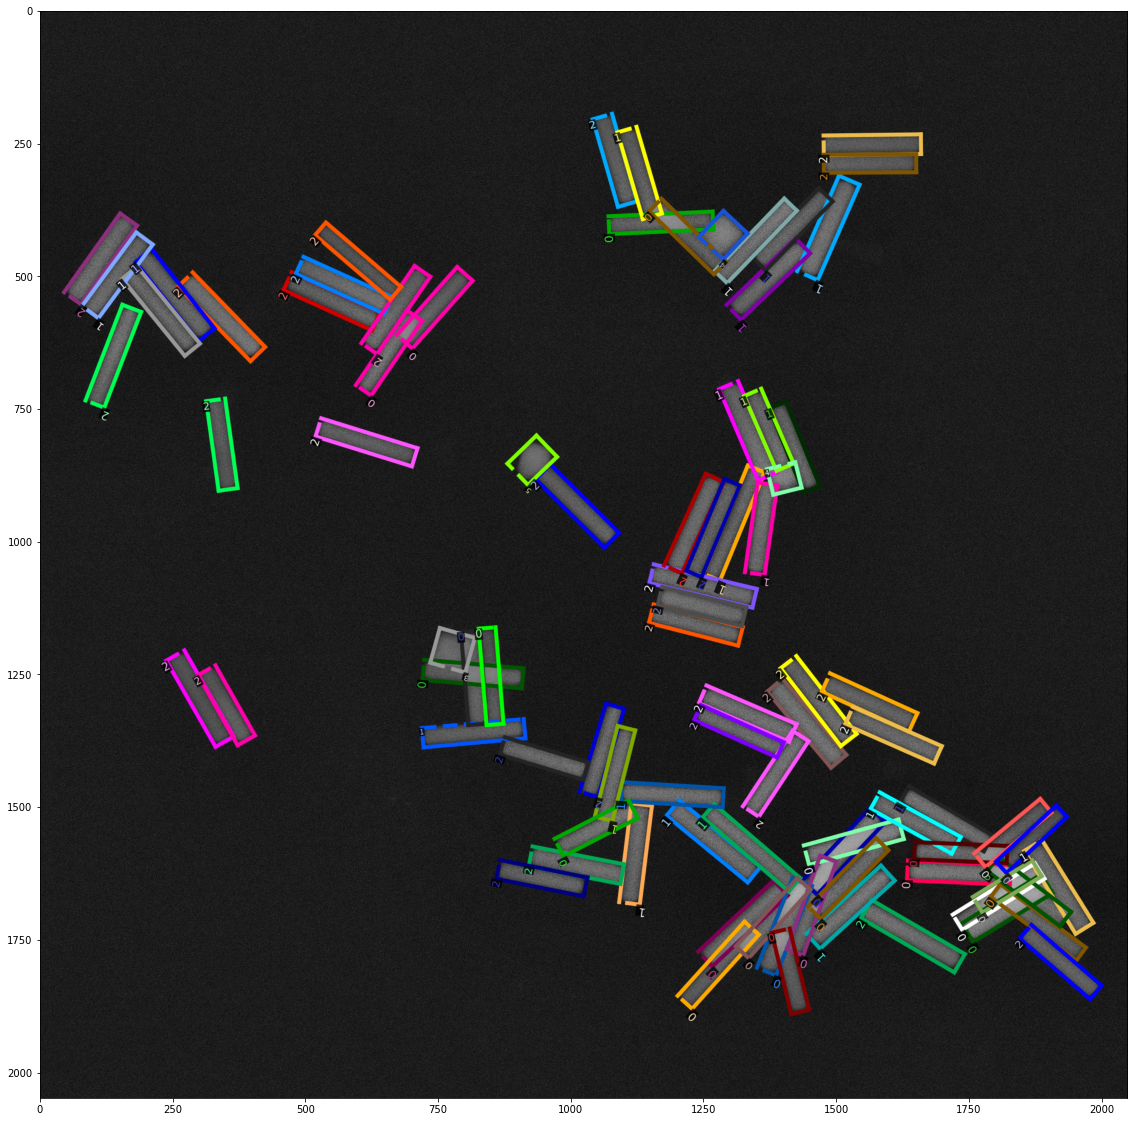

In [7]:
img_dir = f'/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train/'

fig, ax = plt.subplots(figsize=(20, 20))
for i in np.random.choice(DatasetCatalog.get(dataset_train), 1, replace=False):
    img = cv2.imread(i["file_name"])
    visualizer = myVisualizer(img[:, :, ::-1], scale=0.5)
    out = visualizer.draw_dataset_dict(i)
    ax.imshow(out.get_image()[:, :, ::-1])
    plt.show()


# Visualize Model Predictions

In [1]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from pathlib import Path


EXPERIMENT_NAME = 'nanorods'

dataset_train = f"{EXPERIMENT_NAME}_train"
dataset_val = f"{EXPERIMENT_NAME}_val"
train_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_train_2classes_coco/train.json"
train_img_dir = data_dir + f"/{EXPERIMENT_NAME}_train/"
val_annotation_file = data_dir + f"/{EXPERIMENT_NAME}_val_2classes_coco/val.json"
val_img_dir = data_dir + f"/{EXPERIMENT_NAME}_val/"


NameError: name 'data_dir' is not defined

In [6]:
cfg_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/0/output_2classes/setting_0/config.yaml'
model_weights = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/0/output_2classes/setting_0/model_0001999.pth'

cfg = get_cfg()
cfg.merge_from_file(cfg_file)
cfg.MODEL.WEIGHTS = model_weights
cfg.MODEL.DEVICE = 'cpu'

# predictor = RotatedPredictor(cfg)
predictor = DefaultPredictor(cfg)


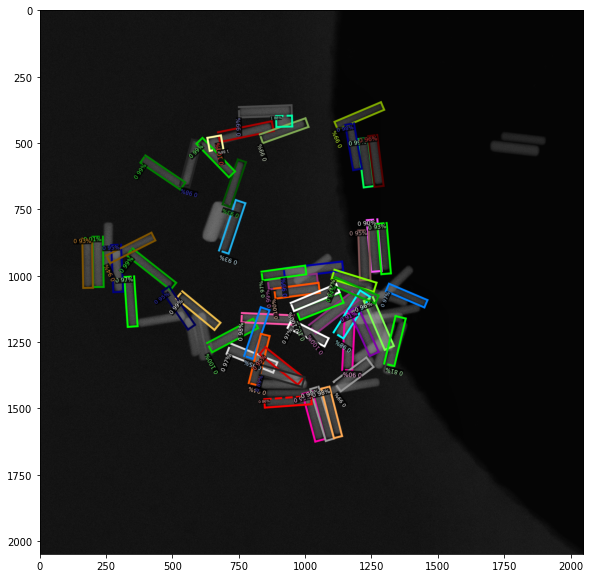

In [15]:
img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_train/20210517 0009 HAADF.tif'
# img_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Data/nanorods_val/20210517 0002 HAADF.tif'

im = cv2.imread(img_file)
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = myVisualizer(im[:, :, ::-1],
              metadata=MetadataCatalog.get(dataset_val), 
              scale=0.5)
              # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
# )
out = v.draw_instance_predictions(outputs["instances"])

plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

# COCO metric

In [ ]:
from helpers_rbbox import mapper

def my_convert_to_coco_dict(dataset_dicts, class_name_list):

    coco_images = []
    coco_annotations = []
    coco_categories = [{"id": index, "name": value, "supercategory": "empty"} for
                  index, value in enumerate(class_name_list)]

    for image_dict in dataset_dicts:
        coco_image = {
            "id": int(image_dict["image_id"]),
            "width": image_dict["width"],
            "height": image_dict["height"],
            "file_name": image_dict["file_name"],
        }
        coco_images.append(coco_image)

        for annotation in image_dict["annotations"]:
            coco_annotation = {}

            # COCO requirement: XYWH box format
            bbox = annotation["bbox"]
            bbox_mode = annotation["bbox_mode"]
            # Computing areas using bounding boxes
            bbox_xy = BoxMode.convert(bbox, bbox_mode, BoxMode.XYXY_ABS)
            area = Boxes([bbox_xy]).area()[0].item()

            # COCO requirement:
            #   linking annotations to images
            #   "id" field must start with 1
            coco_annotation["id"] = len(coco_annotations) + 1
            coco_annotation["image_id"] = coco_image["id"]
            coco_annotation["bbox"] = [round(float(x), 3) for x in bbox]
            coco_annotation["area"] = float(area)
            coco_annotation["iscrowd"] = 0
            coco_annotation["category_id"] = annotation["category_id"]

            coco_annotations.append(coco_annotation)

    info = {
        "date_created": str(datetime.datetime.now()),
        "description": "Automatically generated COCO json file for Detectron2.",
    }

    coco_dict = {
        "info": info,
        "images": coco_images,
        "annotations": coco_annotations,
        "categories": coco_categories,
        "licenses": None,
    }
    return coco_dict


def my_convert_to_coco_json(output_file, dataset_dicts, class_name_list):
    coco_dict = my_convert_to_coco_dict(dataset_dicts, class_name_list)

    PathManager.mkdirs(os.path.dirname(output_file))
    with PathManager.open(output_file, "w") as f:
        json.dump(coco_dict, f)

# Bug in RotatedCOCOEvaluator where it gets passed img_ids
class MyRotatedCOCOEvaluator(RotatedCOCOEvaluator):
    def _eval_predictions(self, tasks, predictions, img_ids=None):
        super()._eval_predictions(tasks, predictions)

In [ ]:
# Create coco evaluator, but use the default detectron2 data format for generation, make sure ids overlap
evaluator = MyRotatedCOCOEvaluator(dataset_val, cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, dataset_val, mapper=mapper) 
outputs = inference_on_dataset(predictor, val_loader, evaluator)


In [1]:
model_weight_file = '/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/0/output_/setting_0/model_0001999.pth'

'/'.join(model_weight_file.split('/')[:-1]) + '/config.yaml'



'/usr/workspace/zhong2/Research/FeedOpt/Questek/Results/Tuning_nanorods/0/output_/setting_0'

### Correct extra class labels in annotation part1

In [ ]:
dir_old = '/Users/zhong2/Desktop/Data/QuesTek/20210517-NanoRods_lables/nanorod_lables_part1_raw/'
dir_new = '/Users/zhong2/Desktop/Data/QuesTek/20210517-NanoRods_lables/nanorod_lables_part1/'
labels_1to2 = {'2':'3', '3':'1', '4':'6', '5':'4', '7':'2', '9':'5'}


for file in os.listdir(dir_old):
# file = '20210517 0001 HAADF.txt'
    if file != 'classes.txt':
        new = []
        file_old = open(dir_old + file,"r")
        old = file_old.readlines()
        file_old.close()
        for old_line in old:
            new.append(labels_1to2[old_line[0]] + old_line[1:])

        file_new = open(dir_new + file,"w")
        file_new.writelines(new)
        file_new.close()